# Quantitaive Experiment Evaluation

To get some inspiration, e.g. seaborn, plotly and brokeh looks great https://mode.com/blog/python-data-visualization-libraries/

---

In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
import pickle

%matplotlib inline

---

#### Load data from experiment

In [22]:
DATA_PATH = "../../data/experiments/q-10000/latest/csv"
FACTOR = 962  # constant

In [23]:
def load_files(path_to_files):
    files_it = os.scandir(path_to_files)
    frames = {}
    
    for file in files_it:
        if file.is_file() and file.name.startswith('fm-') and file.name.endswith('.csv'):
            frame = pd.read_csv(file.path)
            
            version = file.name.replace('fm-', '')
            version = version.replace('.csv', '')
            major, minor = version.split('-')
            
            major = int(major)
            minor = int(minor)
            
            if major in frames:
                frames[major] = pd.concat([frames[major], frame])
            else:
                frames[major] = frame
        
    return dict(sorted(frames.items()))

In [187]:
dfs = load_files(DATA_PATH)[FACTOR]

In [190]:
dfs = dfs.reset_index(drop=True)

---

#### Describe

In [191]:
dfs.columns

Index(['originalP', 'customSP', 'simpleSP', 'trueClass'], dtype='object')

Columns:
 - **originalP**: prediction of the examined model on the entire instance
 - **customSP**: prediction of the examined model on the custom (explanation) summaries
 - **simpleSP**: prediction of the examined model on the simple (TextRank) summaries without altering weights
 - **trueClass**: true class of the original instance, (0 = negative, 1 = positive)

In [192]:
dfs.shape[0]

10000

**10.000** instances were used to get the results. Each instance had **15 and more sentences**

In [193]:
dfs.dtypes

originalP    float64
customSP     float64
simpleSP     float64
trueClass    float64
dtype: object

In [194]:
dfs.trueClass = dfs.trueClass.astype(int)

In [195]:
dfs.trueClass.value_counts()

0    5274
1    4726
Name: trueClass, dtype: int64

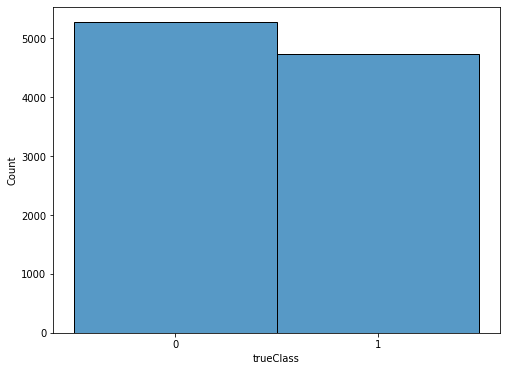

In [196]:
plt.figure(figsize=(8, 6));
ax = sns.histplot(data=dfs, x="trueClass", discrete=True);
ax.set_xticks([0,1]);

---

#### Predictions

In [149]:
dfs.originalP.describe()

count    10000.000000
mean         0.450261
std          0.457789
min          0.000000
25%          0.002400
50%          0.188265
75%          0.989023
max          1.000000
Name: originalP, dtype: float64

In [150]:
dfs.customSP.describe()

count    10000.000000
mean         0.463984
std          0.433135
min          0.000000
25%          0.011775
50%          0.339885
75%          0.969360
max          1.000000
Name: customSP, dtype: float64

In [151]:
dfs.simpleSP.describe()

count    10000.000000
mean         0.465481
std          0.426667
min          0.000000
25%          0.016258
50%          0.367360
75%          0.963588
max          1.000000
Name: simpleSP, dtype: float64

<AxesSubplot:>

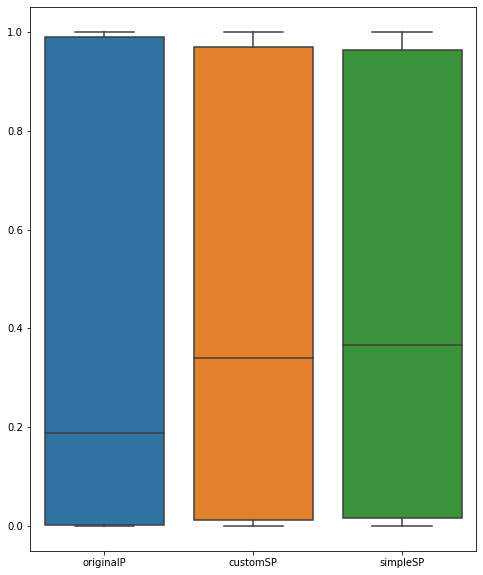

In [197]:
plt.figure(figsize=(8, 10));
sns.boxplot(data=dfs[['originalP', 'customSP', 'simpleSP']], )

<Figure size 864x864 with 0 Axes>

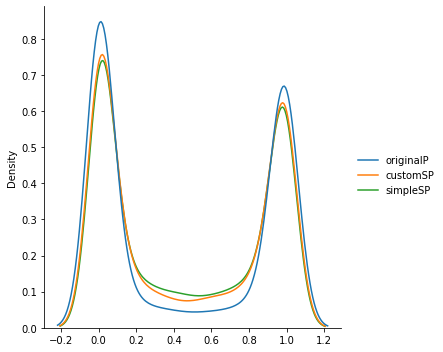

In [200]:
plt.figure(figsize=(12, 12));
sns.displot(data=dfs[['originalP', 'customSP', 'simpleSP']], );

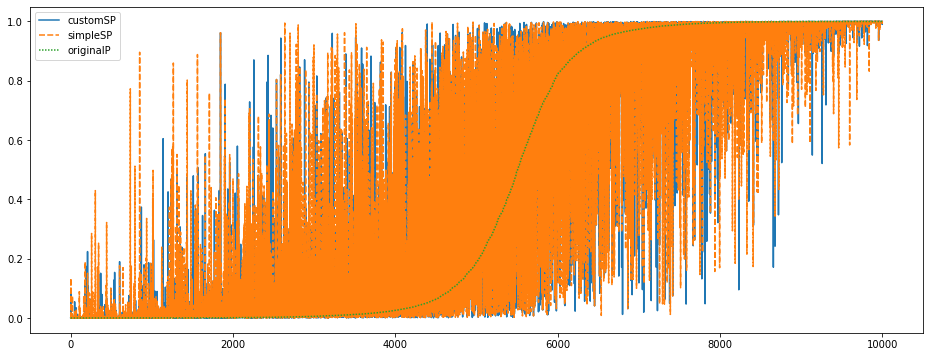

In [210]:
plt.figure(figsize=(16, 6));
d = dfs.sort_values(by='originalP')[['customSP', 'simpleSP', 'originalP']].reset_index(drop=True)

sns.lineplot(data=d)
del d

/home/tomasmizera/school/diploma/src/env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


<AxesSubplot:xlabel='originalP'>

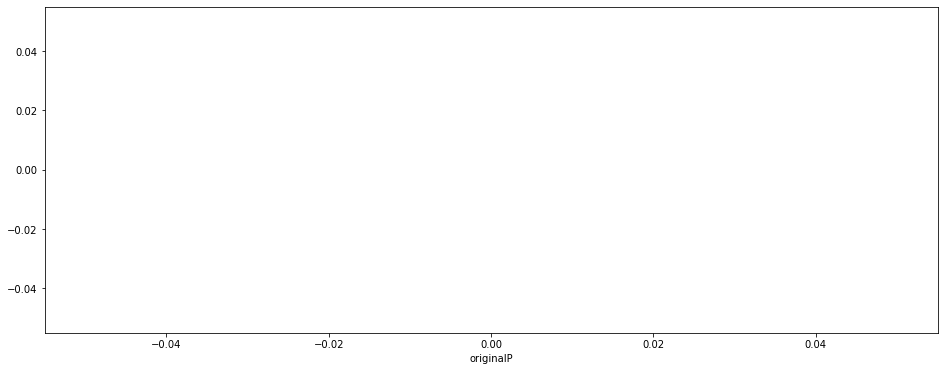

In [212]:
plt.figure(figsize=(16, 6));
d = dfs.sort_values(by='originalP')[['customSP', 'simpleSP', 'originalP']].reset_index(drop=True)

sns.lineplot(data=d, x='originalP')

In [ ]:
# Normalize values to custom bounds https://stackoverflow.com/a/48109733/7875594
def normalize(values, bounds):
    if bounds['actual']['upper'] == bounds['actual']['lower']:
        return values
    return [bounds['desired']['lower'] + (abs(x) - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / 
            (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]


def process_mean(df):
    df = df.reset_index(drop=True)
    
    df['difSimple'] = df.originalP - df.simpleSP
    df['difCustom'] = df.originalP - df.customSP
    return df.difCustom.mean(), df.difSimple.mean()


def process_mse(df, maxval, minval):
    """
    From input dataframe returns 2 MSE errors: (1) error from custom summaries, (2) error from simple summaries
    """
    
    df = df.reset_index(drop=True)
    
    # 1. normalize to (-1, 1)
    bounds = {'actual': {'lower':minval, 'upper':maxval}, 'desired':{'lower':-1, 'upper':1}}
    df['normOriginal'] = normalize(df.originalP, bounds)
    df['normCustom'] = normalize(df.customSP, bounds)
    df['normTextRank'] = normalize(df.simpleSP, bounds)
    
    # 2. subtract textrank and custom predictions from model prediction on entire instance to get errors
    df['errorTextRank'] = df.normOriginal - df.normTextRank
    df['errorCustom'] = df.normOriginal - df.normCustom
    
    # 3. square errors
    df['errorTextRank'] = df.errorTextRank ** 2
    df['errorCustom'] = df.errorCustom ** 2
    
    # 4. find mean
    arr = np.array([df.errorCustom.mean(), df.errorTextRank.mean()])
    
    # 5. square root errors
    arr = np.sqrt(arr)
    
    return arr[0], arr[1]
    
    # squareroot
    # mean of that
    return df.difCustom.mean(), df.difSimple.mean()

def process(dfs, error_func):
    data = {}
    
    mmin = 1
    mmax = 0
    # first max and min prediction across all predictions
    for d in dfs.items():
        ma = max(d[1].originalP.max(),
                 d[1].customSP.max(),
                 d[1].simpleSP.max()
                )
        mi = min(d[1].originalP.min(),
                 d[1].customSP.min(),
                 d[1].simpleSP.min()
                )
        if mi < mmin:
            mmin = mi
        if ma > mmax:
            mmax = ma
    
    
    for d in dfs.items():
        ix = d[0]
        if error_func == 'mse':
            data[int(ix)] = process_mse(d[1], mmax, mmin)
        elif error_func == 'mean':
            data[int(ix)] = process_mean(d[1])
    return data
